In [1]:
import random
import time
import enum
import math
from collections import namedtuple
from multiprocessing.pool import Pool
from typing import Tuple, NamedTuple, List
from tqdm import tqdm

import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
from scipy.ndimage.filters import gaussian_filter

from networkgen import Network, NetworkType
from model import OpinionModel, OpinionAgent, Opinion

In [2]:
#n, p = 100, 0.3 # DEFAULT
#n, k, p = 100, 10, 0.2 # SMALLWORLD
#l, k = 10, 5 # CAVEMAN
#n, s, v, p_in, p_out = 100, 5, 10, 0.3, 0.1 # GAUSSIAN_RANDOM_PARTITION
#n, k = 100, 10 # WINDMILL
#n, p = 100, 0.02  # ERDOS_RENYI
l, k, p, f = 6, 5, 0.1, 0.1 # RELAXED_CAVEMAN

network_params = (l, k, p, f)
initial_believers = 1.0
agent_params = OpinionAgent.Params(initial_opinion=0.25, weight_decay=0.0)
model = OpinionModel(initial_believers, agent_params, network_type=NetworkType.RELAXED_CAVEMAN, network_params=network_params)

In [3]:
model.run(40)


In [4]:
#not used anymore
def create_model(network_type, *network_params, initial_believers: float, initial_opinion, weight_decay):
    #n = len(Network.generate(network_type, *params).nodes)
    agent_params = OpinionAgent.Params(initial_opinion, weight_decay)
    return OpinionModel(initial_believers, agent_params, network_type, *network_params)

In [5]:
def sum_agents(model):

    agent_data = model.data_collector.get_agent_vars_dataframe()
    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data.reset_index(), index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)
    # relabel
    labels = ['Disagree','Believer','Unsure']
    agents_summed.columns = labels[:len(agents_summed.columns)]
    return agents_summed

def plot_agent_opinion(model):
    steps = model.schedule.steps
    X = sum_agents(model)
    X.plot(lw = 4, alpha = 0.8)

In [6]:
def draw_network(with_labels=False):
    node_color = [i.state for i in model.grid.get_all_cell_contents()]
    edge_weights = [model.network.edges[u, v]['weight'] for u, v in model.network.edges]
    #layout = nx.kamada_kawai_layout(model.network, weight=1.0, scale=10)
    dummy = nx.connected_caveman_graph(7, 5)
    layout=nx.circular_layout(model.network)
    #layout = nx.circular_layout(model.network, scale=10)
    nx.draw_networkx(model.network, pos=layout, node_size = 100, arrowsize=5.0, edge_cmap=plt.cm.binary, edge_color=edge_weights, node_color=node_color, cmap=plt.cm.plasma, edge_vmin=0.0, edge_vmax=1.0, vmin=0.0,vmax=1.0, with_labels=with_labels, labels={i: f"{node_color[i]:.2f}" for i in range(len(node_color))})
    plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap=plt.cm.plasma))

In [7]:
def draw_network_discrete():
    color_code = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])

    states = [int(i.state) for i in model.grid.get_all_cell_contents()]

    colors = [color_code(i) for i in states]

    layout = nx.kamada_kawai_layout(model.network, weight=1.0, scale=10)
    nx.draw_networkx(model.network, pos=layout, node_size = 100, arrowsize=5.0, width=1.0, node_color=colors, with_labels=False)

In [8]:
for i in tqdm(range(10000)):
    #print(f"i={i}")
    ##draw_network_discrete()
    #draw_network()
    #plt.show()
    if i % 100 == 0 and False:
        plt.hist([agent.state for agent in model.grid.get_all_cell_contents()], range=(0,1), bins=20)
        plt.show()
    model.step()

100%|██████████| 10000/10000 [00:51<00:00, 195.59it/s]


In [44]:
z = np.zeros((20,20))

for i in tqdm(range(20)):
    for j in range(20):
        l, k, p, f = 6, 5, 0.1, 0.1 # RELAXED_CAVEMAN
        network_params = (l, k, p, i/20)
        initial_believers = 1.0
        agent_params = OpinionAgent.Params(initial_opinion=0.25, weight_decay=0.0)
        model = OpinionModel(j / 20, agent_params, network_type=NetworkType.RELAXED_CAVEMAN, network_params=network_params)
        model.run(40)
        z[i][j] = sum([agent.state for agent in model.grid.get_all_cell_contents()])/len([agent.state for agent in model.grid.get_all_cell_contents()])

100%|██████████| 20/20 [02:03<00:00,  6.20s/it]


In [39]:
print(z)

[[0.00354962 0.00244033 0.00253757 0.00360899 0.00320181 0.00248505
  0.00202427 0.03135923 0.00309356 0.15914232 0.00308604 0.00385469
  0.00223819 0.15378904 0.57728136 0.00334143 0.00277623 0.0017825
  0.57106949 0.7445456 ]
 [0.00398977 0.00363373 0.00303607 0.00434664 0.00278938 0.00289419
  0.00370681 0.00365557 0.0031892  0.00283324 0.00307359 0.00188567
  0.0026907  0.00301611 0.00304218 0.00287579 0.0025334  0.00364521
  0.00429165 0.00266662]
 [0.00359837 0.00337293 0.00338798 0.00229394 0.00234929 0.00400837
  0.00352727 0.00286185 0.00319689 0.00270308 0.00374574 0.00266078
  0.00306059 0.00385992 0.00259183 0.00378706 0.00293843 0.00378172
  0.88187476 0.90906283]
 [0.00260239 0.00294535 0.00409446 0.00257192 0.00360851 0.00293451
  0.00418465 0.00183463 0.00232755 0.00240199 0.00360354 0.00284102
  0.00379124 0.00306693 0.00364838 0.00306151 0.00259618 0.00188179
  0.00270613 0.00169175]
 [0.00340504 0.00266919 0.00369092 0.0033576  0.002094   0.00339651
  0.00311311 0.00

In [42]:
def draw_phase_diagram(r):
    x = np.linspace(0, 1, 20)
    y = np.linspace(0, 100, 20)

    """
    z = gaussian_filter(r, sigma=7, mode='wrap')
    z -= np.min(z)
    z /= np.max(z)
    """

    z = r

    fig, ax = plt.subplots()
    cmap = ax.pcolormesh(x, y, z)
    fig.colorbar(cmap)
    plt.xlabel("fraction of edges that are not in the original graph")
    plt.ylabel("Number of initial believers")
    plt.show(fig)

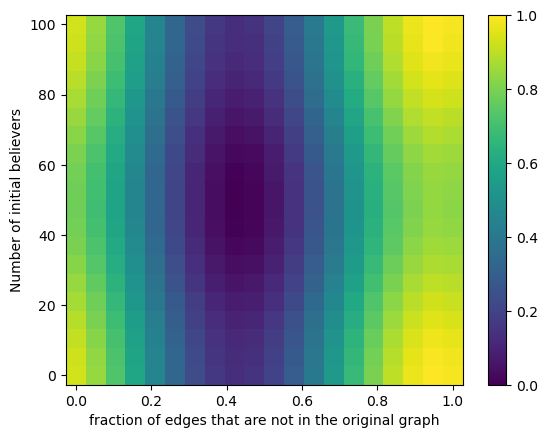

In [43]:
draw_phase_diagram(z)

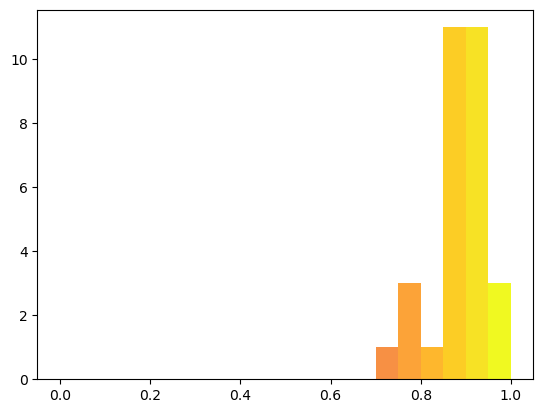

In [13]:

def draw_histogram():
    # This is  the colormap I'd like to use.
    cm = plt.cm.plasma

    # Plot histogram.
    n, bins, patches = plt.hist([agent.state for agent in model.grid.get_all_cell_contents()], range=(0,1), bins=20)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

draw_histogram()

In [14]:
[agent.state for agent in model.grid.get_all_cell_contents()]

[0.9297054761486526,
 0.8585991077929945,
 0.8958484446462404,
 0.9150663764811409,
 0.8971786660000074,
 0.8876938482239293,
 0.9092434238382537,
 0.8504453814681933,
 0.9550478261943752,
 0.9233119332661767,
 0.911243663747288,
 0.9365756796130061,
 0.8344112326200864,
 0.9551539769625155,
 0.7666796972177625,
 0.7031737987942007,
 0.8773233521690141,
 0.866876474708198,
 0.8737421396579924,
 0.9378816693863182,
 0.9094310119249208,
 0.7991281421663112,
 0.9196519926175529,
 0.8789508001961018,
 0.7598444840293129,
 0.8818030369364708,
 0.9184052650619745,
 0.8591415289831529,
 0.9546087034048146,
 0.9109004292374863]

In [15]:
#not used anymore
def plot_network_visualization(model: OpinionModel):
    color_code = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    colors = [color_code(i) for i in states]
    nx.draw_kamada_kawai(model.network, node_size = 100, edge_color = 'black', node_color = colors)

In [16]:
#pass the model, run it, and plot it - not used here 
def driver(network_type, *params, initial_believers, initial_opinion, weight_decay):
    model = create_model(network_type, params, initial_believers = initial_believers, initial_opinion = initial_opinion, weight_decay = weight_decay)
    model.run(40)
    plot_agent_opinion(model)
    return model

In [17]:
#not used here
def plot_network(model):
    plot_network_visualization(model)

In [18]:
"""
outcome_matrix = np.zeros((100,100))

for i in range (100):
    for j in range (100):
        model = driver(NetworkType.CAVEMAN, 5, 10, initial_believers = i / 100, p_opinion_change = j / 100)
        outcome_matrix[i][j] = 0
model = driver(NetworkType.CAVEMAN, 5, 10, initial_believers = 0.3, initial_opinion=0.9, weight_decay=0.1)
"""

'\noutcome_matrix = np.zeros((100,100))\n\nfor i in range (100):\n    for j in range (100):\n        model = driver(NetworkType.CAVEMAN, 5, 10, initial_believers = i / 100, p_opinion_change = j / 100)\n        outcome_matrix[i][j] = 0\nmodel = driver(NetworkType.CAVEMAN, 5, 10, initial_believers = 0.3, initial_opinion=0.9, weight_decay=0.1)\n'

In [19]:
def phase_diagram(model):
    z = [agent.state for agent in model.grid.get_all_cell_contents()]
    